# CHEM 101.6 Project1

This is a Jupyter notebook for running and analyzing a Molecular Dynamics (MD) simulations of Butane using the OpenMM engine 

---
---
# **Setting the environment for MD calculation**

Firstly, we need to install all necessary libraries and packages for our simulation. The main packages we will be installing are:

1.    OpenMM (https://openmm.org/)
2.    PyTraj (https://amber-md.github.io/pytraj/latest/index.html)
3.    py3Dmol (https://pypi.org/project/py3Dmol/)
4.    Numpy (https://numpy.org/)
5.    Matplotlib (https://matplotlib.org/)
8.    AmberTools (https://ambermd.org/AmberTools.php)

Load libraries in conda enviroment:

conda install -c conda-forge openmm 

conda install -y -q -c conda-forge openmm=7.6 python=3.7 pdbfixer

conda install -c conda-forge ambertools

conda install -c ambermd pytraj 

conda install -c conda-forge biopandas

conda install -c conda-forge mdanalysis

conda install -c conda-forge py3dmol

conda install -c conda-forge jupyterlab

conda install -c conda-forge mdtraj

conda install -c conda-forge nglview



In [1]:
from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit
import mdtraj as md
from sys import stdout
import time as time
import ipywidgets
from ipywidgets import interact, fixed
import warnings
import nglview as ngl
from nglview.player import TrajectoryPlayer
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

In [2]:
datadir='/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2'
workDir='/Users/albertchen/Desktop/CHEM.101.6/Project_1/outdir'
initial_pdb='/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2/butane.pdb'
force_field='/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2/butane.gaff2.xml'

if not os.path.exists(workDir):
    os.makedirs(workDir)
    
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)

/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2/butane.pdb
/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2/butane.gaff2.xml


In [3]:
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")

Minimizing...
Potential energy before minimization is 5.7967068665512445 kJ/mol
Potential energy after minimization is 5.298273975341779 kJ/mol


In [4]:
from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)

Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,29.03867960108979,219.91840965610086
200,22.13359932236212,292.64323117742487
300,43.91425016563624,256.79652635818104
400,59.25397610932392,237.09738994470098
500,40.60559578776949,238.3217100185688
600,52.53734243921964,390.32812165766177
700,29.217963140409424,388.1550067159574
800,35.521286910881926,255.54997682756587
900,64.68591593297378,191.57854993282368
1000,25.27824992185989,337.3599784514161
1100,29.649720890022223,366.0811442488401
1200,35.96187369920559,276.4622237668118
1300,54.594455045006114,317.393342531631
1400,42.079328523426156,257.2435351629497
1500,41.021583297903184,253.56284565464864
1600,45.99146379289465,334.6975741444614
1700,44.03907536323688,322.6663655136631
1800,43.74804328470557,389.8716240461141
1900,47.08747259353149,270.20878834573233
2000,34.73130023392811,381.54870479320533
2100,48.34284939321096,449.1507379318138
2200,49.313232093647756,351.2899941405081
2300,53.03773019219

In [5]:
import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(1000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')

Running Production...
#"Step","Time (ps)","Potential Energy (kJ/mole)","Temperature (K)","Speed (ns/day)"
250000,500.0000000016593,57.58250549506921,253.00613637651819,0
500000,999.9999999901769,34.20461277626805,335.2389684033253,1.97e+04
750000,1499.9999999783536,29.35483920773166,199.6451408207707,1.98e+04
1000000,1999.9999999665301,32.138345260634,305.72951229856864,1.96e+04
Done!
Time required for simulation: 8.852756977081299 seconds


In [24]:
#print(workDir+'butane_sim.dcd')
#simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))

#IMPORTANT NOTE: I just used your DCD file from slack since the simulation 
#I got from mine gave me some weird results such as the correlations not really 
#matching your results.

traj = md.load('butane_sim.dcd', top=initial_pdb)
traj
#traj.superpose(ref)

<mdtraj.Trajectory with 10000 frames, 14 atoms, 1 residues, without unitcells at 0x7fecc04e7c90>

In [25]:
#jupyter-nbextension enable --py --user nglview
#jupyter-nbextension enable --py --user widgetsnbextension 

traj = md.load('butane_sim.dcd', top=initial_pdb)
t = ngl.MDTrajTrajectory(traj)
w = ngl.NGLWidget(t)
w

NGLWidget(max_frame=9999)

In [26]:
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


In [27]:
#Lets select the topology
top=traj.topology
top

<mdtraj.Topology with 1 chains, 1 residues, 14 atoms, 13 bonds at 0x7fed036207d0>

In [28]:
#Select All Carbon Atoms
C_sel=top.select("type C")
print(C_sel)
#Confirm that we have selected what we think we have
for atom in C_sel:
    print(top.atom(atom))

[ 0  4  7 10]
NBU1-C1
NBU1-C2
NBU1-C3
NBU1-C4


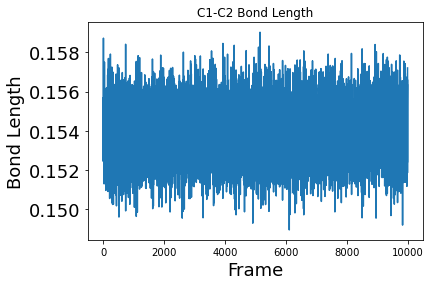

In [29]:
#Compute Some Distances and plot the time course
bond_indices = [0, 4] 
C1C2bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C1C2bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=10)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C1-C2 Bond Length')
plt.show()

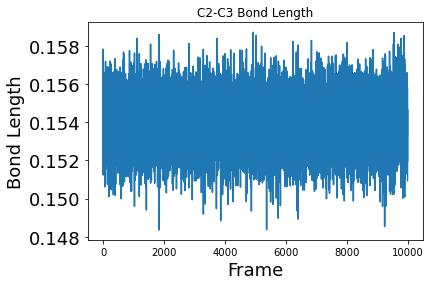

In [30]:
bond_indices = [4, 7] 
C2C3bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C2C3bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=10)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C2-C3 Bond Length')
plt.show()

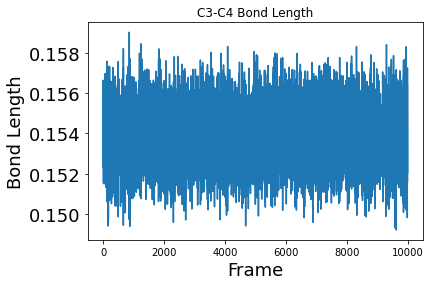

In [31]:
bond_indices = [7, 10] 
C3C4bondlength = md.compute_distances(traj, [bond_indices])
plt.plot(C3C4bondlength)
plt.xlabel('Frame', size=18)
plt.xticks(size=10)
plt.yticks(size=18)
plt.ylabel('Bond Length', size=18)
plt.title('C3-C4 Bond Length')
plt.show()

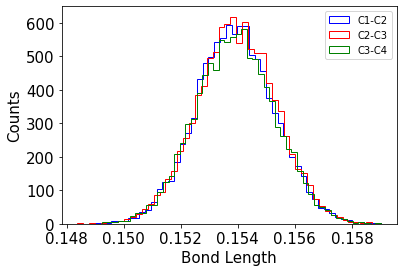

In [32]:
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html
plt.hist(C1C2bondlength,label='C1-C2',color='b',histtype='step',bins=50)
plt.hist(C2C3bondlength,label='C2-C3',color='r',histtype='step',bins=50)
plt.hist(C3C4bondlength,label='C3-C4',color='g',histtype='step',bins=50)
plt.legend(loc='upper right')
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()

Lets Write Functions to Calculate the Variance ($\sigma^2$) and Standard Deviation ($\sigma$)

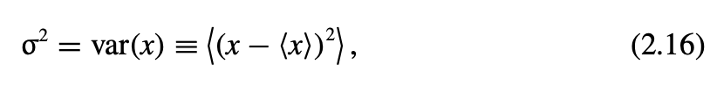

In [33]:
######Class Activtiy: Calculate the Variance and Standard Deviation of Each Bond Length######


In [34]:
###SOLUTION###
import numpy as np

def variance(data):
    ave=np.average(data)
    var= np.average((data-ave)**2)
    std=var**0.5
    return var,std

C1C2var,C1C2std=variance(C1C2bondlength)
C2C3var,C2C3std=variance(C2C3bondlength)
C3C4var,C3C4std=variance(C3C4bondlength)
print("C1-C2 var:",C1C2var,"C2-C3 var:",C2C3var,"C3-C4 var:",C3C4var)
print("C1-C2 std:",C1C2std,"C2-C3 std:",C2C3std,"C3-C4 std:",C3C4std)

C1-C2 var: 1.877708e-06 C2-C3 var: 1.9097258e-06 C3-C4 var: 1.9028457e-06
C1-C2 std: 0.001370294848967931 C2-C3 std: 0.0013819282993662366 C3-C4 std: 0.0013794367417696333


In [35]:
#Lets Check Our Answers with the Built In Numpy Libraries
print("C1-C2 average:",np.average(C1C2bondlength),"variance:",np.var(C1C2bondlength),"std-dev:",np.std(C1C2bondlength))
print("C2-C3 average:",np.average(C2C3bondlength),"variance:",np.var(C2C3bondlength),"std-dev:",np.std(C2C3bondlength))
print("C3-C4 average:",np.average(C3C4bondlength),"variance:",np.var(C3C4bondlength),"std-dev:",np.std(C3C4bondlength))

C1-C2 average: 0.15391365 variance: 1.877708e-06 std-dev: 0.0013702948
C2-C3 average: 0.15394597 variance: 1.9097258e-06 std-dev: 0.0013819283
C3-C4 average: 0.15390207 variance: 1.9028457e-06 std-dev: 0.0013794367


***Class Activity: Lets Check if These Bond Lengths Are Correlated and Calculate the Coerrleation Coefficents***

***First Calculate a Best Fit Line****

We can do this using the np.polyfit function:

https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html

***Now Calculate the Perason Correlation Coefficient***
We can use numpy to calculate the correlation coeffient 

https://numpy.org/doc/stable/reference/generated/numpy.corrcoef.html

This function works for n-arrays, so it will report correlation coefficient matrix, and we need to select our coefficient of interest, which in our case is the off diagnol  


Line Parameters: [-0.0775146   0.16587652]


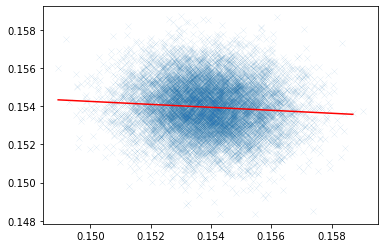

r2: -0.07686206044416956
Line Parameters: [0.00388825 0.15330362]


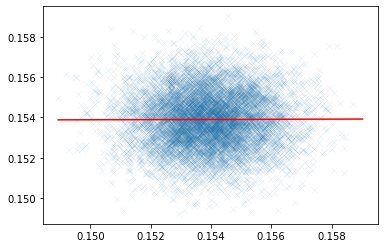

r2: 0.0038624771537713524


In [36]:
#####Are these bond lengths correlated?##### 
###Calculate and plot a best fit line, and calculate the correlation coefficient####

plt.scatter(C1C2bondlength,C2C3bondlength,marker='x',linewidth=0.05)

#######SOLUTION###########


line_fit=np.polyfit(C1C2bondlength[:,0],C2C3bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C2C3bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()
plt.clf()

r=np.corrcoef(C1C2bondlength[:,0], C2C3bondlength[:,0])
print("r2:",r[0,1])

plt.scatter(C1C2bondlength,C3C4bondlength,marker='x',linewidth=0.05)

line_fit=np.polyfit(C1C2bondlength[:,0],C3C4bondlength[:,0],1)
x = np.linspace(min(C1C2bondlength[:,0]), max(C1C2bondlength[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print("Line Parameters:",line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.show()

r=np.corrcoef(C1C2bondlength[:,0], C3C4bondlength[:,0])
print("r2:",r[0,1])

**Homework Question:  Why does one pair of these bonds appear more correlated than the other?**

Because the first pair shares an atom in common (C2) while the other pair shares no atoms in common. Thus, there will be something to correlate the bond lengths of the first pair (both bonds will feel the effects of C2 moving around).

***Class Activity*** 

Lets Turn these histograms into a probability densities and then fit them to a
normal (Gaussian) Distribution

https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

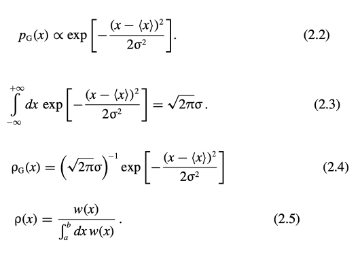
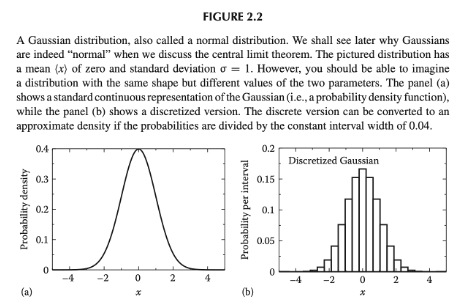

array of x and y data points: 
 [0.14732501 0.147975   0.148625   0.149275   0.149925   0.15057501
 0.151225   0.15187499 0.15252501 0.153175   0.153825   0.154475
 0.15512499 0.15577501 0.156425   0.15707499 0.157725   0.158375
 0.159025   0.159675  ] [0.000e+00 0.000e+00 1.000e-04 7.000e-04 3.300e-03 9.400e-03 2.920e-02
 5.990e-02 1.162e-01 1.668e-01 1.886e-01 1.692e-01 1.221e-01 7.600e-02
 3.750e-02 1.490e-02 4.900e-03 1.000e-03 2.000e-04 0.000e+00] 

a: 0.18761157866951292 x0: 0.1538894668943878 fit_sigma: -0.0013787523302921205 

array of x and fitted y data points:  [0.14732501 0.147975   0.148625   0.149275   0.149925   0.15057501
 0.151225   0.15187499 0.15252501 0.153175   0.153825   0.154475
 0.15512499 0.15577501 0.156425   0.15707499 0.157725   0.158375
 0.159025   0.159675  ] [2.24303722e-06 1.89399016e-05 1.28060390e-04 6.93308073e-04
 3.00537422e-03 1.04321055e-02 2.89932620e-02 6.45209774e-02
 1.14972159e-01 1.64039865e-01 1.87406644e-01 1.71433151e-01
 1.25569165e-01 7

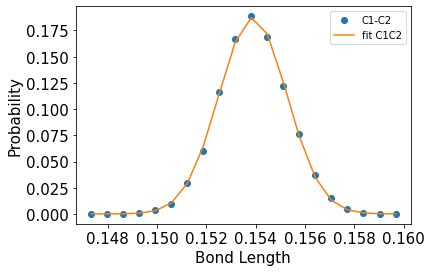

In [37]:
#Lets calculate a Probability Density and fit a gaussian to these
#First lets pull out the data in a formate we can fit
#https://numpy.org/doc/stable/reference/generated/numpy.histogram.html
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html

#The solution was already given in the Jupyter notebook posted on Slack.

from scipy.optimize import curve_fit



#First we convery our histogram into bin centers and probabilities
#isntead of bin edges and counts:

counts, edges = np.histogram(C1C2bondlength, bins=20, range=[0.147,0.160])
centers = edges[:-1] + np.diff(edges)/2
density=counts/np.sum(counts)

###Now we define a gaussian function that we'll fit to our probability densities

def histogram_bincenters(a,x0,xmax,bins):
    counts, edges = np.histogram(a, bins=bins, range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/np.sum(counts)
    return density, centers

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

#### Now we define a function to fit the gaussian with curve fit

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    print("array of x and y data points: \n",x,y,"\n")
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma,"\n")    
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    print("array of x and fitted y data points: ",x,fit_y,"\n")
    return fit_y,[fit_a,fit_x0,fit_sigma] 

C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density)

plt.plot(centers, C1C2_density, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')


plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()


a: 0.18761157866951292 x0: 0.1538894668943878 fit_sigma: -0.0013787523302921205
a: 0.18574440385232668 x0: 0.15395702008504444 fit_sigma: -0.0013965709822283917
a: 0.1853601051719883 x0: 0.15388302289899353 fit_sigma: 0.001400882975052254


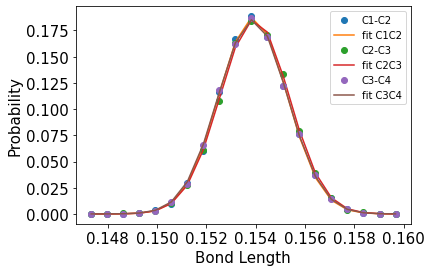

In [38]:
#Can you write a function to calculate the histogram, return the density and centers,
#and then fit a guassian to each of these distributions? 

####SOLUTION####

def histogram_bincenters(a,x0,xmax,bins):
    counts, edges = np.histogram(a, bins=bins, range=[x0, xmax])
    centers = edges[:-1] + np.diff(edges)/2
    density=counts/np.sum(counts)
    return density, centers

def gauss(x, a, x0, sigma):
    return (a*np.exp(-(x-x0)**2/(2*sigma**2)))

def fit_gauss(x,y):
    parameters, covariance = curve_fit(gauss, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss(centers, fit_a, fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]

C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density)

C2C3_density,centers=histogram_bincenters(C2C3bondlength,0.147,0.160,20)
C2C3_fit,C2C3_fit_params=fit_gauss(centers,C2C3_density)

C3C4_density,centers=histogram_bincenters(C3C4bondlength,0.147,0.160,20)
C3C4_fit,C3C4_fit_params=fit_gauss(centers,C3C4_density)


plt.plot(centers, C1C2_density, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')
plt.plot(centers, C2C3_density, 'o', label='C2-C3')
plt.plot(centers, C2C3_fit, '-', label='fit C2C3')
plt.plot(centers, C3C4_density, 'o', label='C3-C4')
plt.plot(centers, C3C4_fit, '-', label='fit C3C4')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

***Homework Porblem 1:  Can you write a function to calculate the histogram, return the density and centers
and fit a guassian to each of these distributions?***

**Homework Problem #2: convert these probability distributions to culmulative distribution functions**

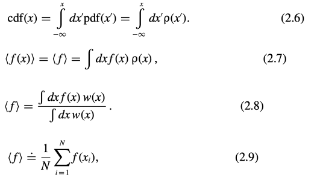

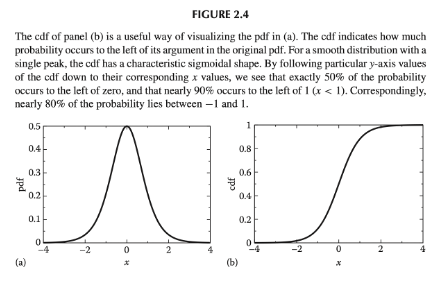

In [39]:
#ADD CODE FOR CDFs HERE#

a: 1.0 x0: 0.15358195226747795 fit_sigma: 0.0004853642091898467


/opt/anaconda3/envs/proj1/lib/python3.7/site-packages/scipy/optimize/minpack.py:834: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


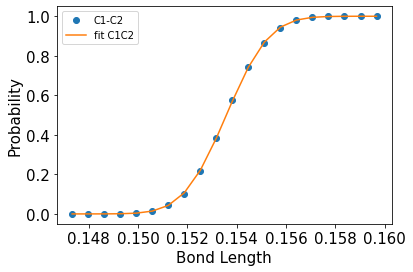

In [40]:
from scipy import special

#From Wikipedia (https://en.wikipedia.org/wiki/Normal_distribution), 
#the function to get a CDF of a Gaussian based on our parameters is this.
def gauss_cdf_formula_conversion(x,fit_a,fit_x0,fit_sigma):
    return 0.5*(1+special.erf((x-fit_x0)/(fit_sigma*(2**2))))

def fit_gauss_cdf(x,y):
    parameters, covariance = curve_fit(gauss_cdf_formula_conversion, x, y)
    fit_a = parameters[0]
    fit_x0 = parameters[1]
    fit_sigma = parameters[2]
    print("a:",fit_a,"x0:",fit_x0,"fit_sigma:",fit_sigma)
    fit_y = gauss_cdf_formula_conversion(centers,fit_a,fit_x0,fit_sigma)
    return fit_y,[fit_a,fit_x0,fit_sigma]

#Based off of our textbook, the way to get a CDF is to integrate over the
#Gaussian, or to sum up all values of y for all values of x. We use this function
#to generate the data points.
def gauss_cdf_summing(y_pdf): #check if need array
    y_cdf=[]
    y_total=0
    for y_curr in y_pdf:
         y_total=y_total+y_curr
         y_cdf.append(y_total)
    return y_cdf

C1C2_density,centers=histogram_bincenters(C1C2bondlength,0.147,0.160,20)
C1C2_density_cdf=gauss_cdf_summing(C1C2_density)
C1C2_fit,C1C2_fit_params=fit_gauss_cdf(centers,C1C2_density_cdf)

plt.plot(centers, C1C2_density_cdf, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')


plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

**Homework Problem #3: Lets draw some different some random frames from our trajectory (for example 10,100, and 1000),  calculate the probability distribution functions for 5 of these random samples, and fit  gaussians to these probability distirbution functions***
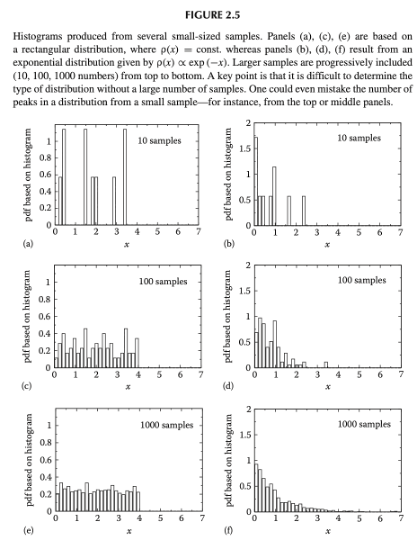

10 samples
a: 0.2846763915534083 x0: 0.15367348532303132 fit_sigma: -0.0009482259774371075


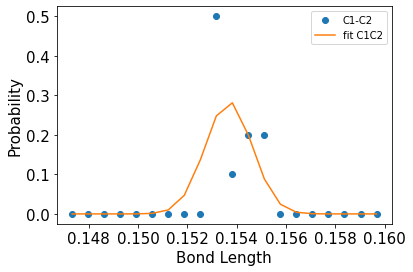

10 samples
a: 0.3078205513279626 x0: 0.15414999643892202 fit_sigma: 0.0008037116472703559


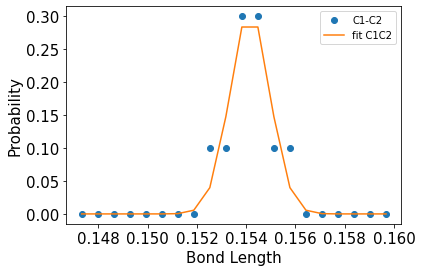

100 samples
a: 0.008597122909311139 x0: -2.228082370409797 fit_sigma: 0.2788115382405847


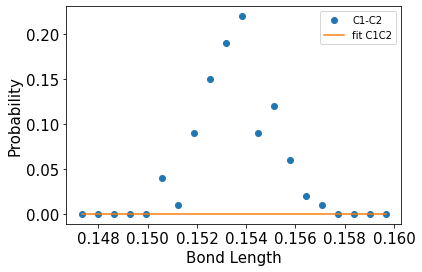

100 samples
a: 0.1824281769840983 x0: 0.15412882649434204 fit_sigma: -0.001406505302854363


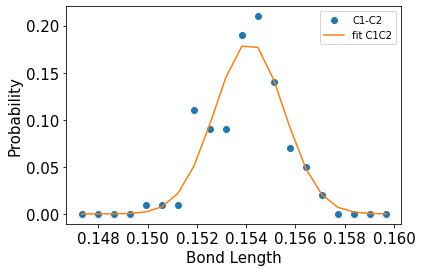

1000 samples
a: 0.19094150906959756 x0: 0.15384220936874374 fit_sigma: 0.0013575212964767522


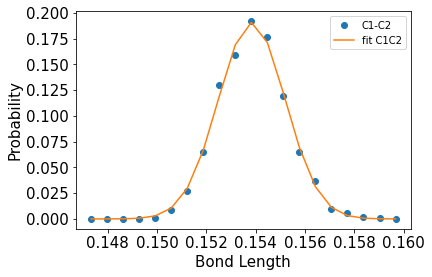

You can really see the dataset becoming more normal as you increase the sample size.


In [41]:
#ADD CODE FOR Random SAMPLES HERE#
#Draw 10,100,1000 random samples of a bond angle,

#This function might be helpful:

def draw_samples(frames,num_samples):
    rands=np.random.randint(0,9999,size=(num_samples))
    #print(rands)
    samples = []
    for index in rands:
        samples.append(frames[index][0])
    return rands+1,samples

#print(C1C2bondlength)
#print(draw_samples(C1C2bondlength,10))

print("10 samples")

C1C2_density_rand,centers=histogram_bincenters(draw_samples(C1C2bondlength,10)[1],0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density_rand)

plt.plot(centers, C1C2_density_rand, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

print("10 samples")

C1C2_density_rand,centers=histogram_bincenters(draw_samples(C1C2bondlength,10)[1],0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density_rand)

plt.plot(centers, C1C2_density_rand, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

print("100 samples")

C1C2_density_rand,centers=histogram_bincenters(draw_samples(C1C2bondlength,100)[1],0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density_rand)

plt.plot(centers, C1C2_density_rand, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

print("100 samples")

C1C2_density_rand,centers=histogram_bincenters(draw_samples(C1C2bondlength,100)[1],0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density_rand)

plt.plot(centers, C1C2_density_rand, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

print("1000 samples")

C1C2_density_rand,centers=histogram_bincenters(draw_samples(C1C2bondlength,1000)[1],0.147,0.160,20)
C1C2_fit,C1C2_fit_params=fit_gauss(centers,C1C2_density_rand)

plt.plot(centers, C1C2_density_rand, 'o', label='C1-C2')
plt.plot(centers, C1C2_fit, '-', label='fit C1C2')

plt.legend()
plt.xlabel('Bond Length', size=15)
plt.xticks(size=15)
plt.ylabel('Probability', size=15)
plt.yticks(size=15)
plt.show()

print("You can really see the dataset becoming more normal as you increase the sample size.")
#You can really see the dataset becoming more normal as you increase the sample size.

**Class Activity: Lets Compute the 2 C-C-C Bond Anlges and C-C-C-C Dihedral Angle ***

Plot their time course and their histograms.  Find a good way to visualize the C-C-C-C dihedral angle 

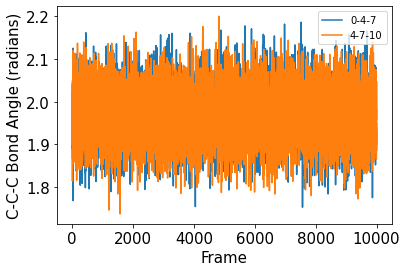

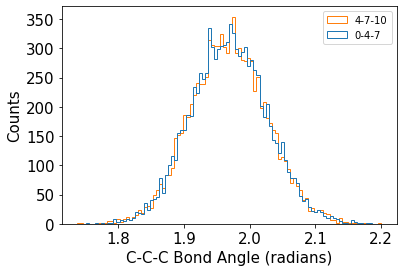

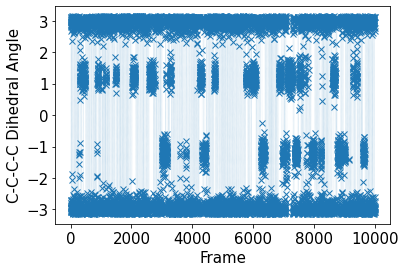

In [42]:
#Lets Compute Some Bond Angles 
Angle1=[0,4,7]
Angle2=[4,7,10]

ang = md.compute_angles(traj,[Angle1,Angle2])
#print(ang)
#ang=np.degrees(angle_rad)
#print(np.shape(ang))
plt.plot(ang,label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('Frame', size=15)
plt.xticks(size=15)
plt.ylabel('C-C-C Bond Angle (radians)', size=15)
plt.yticks(size=15)
plt.show()

plt.show()
plt.clf()
plt.hist(ang,bins=100,histtype='step',label=['0-4-7','4-7-10'])
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()
plt.clf()

CCCC_index=[10,7,4,0]
CCCC_torsion=md.compute_dihedrals(traj, [CCCC_index])
#print(CCCC_torsion)
#print(np.shape(CCCC_torsion))
CCCC_tor_ang = CCCC_torsion[:,0]
#print(CCCC_tor_ang)

#plt.plot(CCCC_torsion)
plt.plot(CCCC_torsion,marker='x',linewidth=.01)
#plt.xlim(0,2000)
plt.xlabel('Frame', size=15)
plt.xticks(size=15)
plt.ylabel('C-C-C-C Dihedral Angle', size=15)
plt.yticks(size=15)
plt.show()



***Homework Challenge Question:  Can you estimate the lifetime of the higher energy C-C-C-C dihedral states?*****

In [43]:
####Challenge Question Can you estimate the lifetime of the higher energy C-C-C-C dihedral states####


**Class Activity: Are The Bond Angles and Dihedral Angle Correlated?**

r2: 0.017526230594715284
[3.77982783e-04 1.96838814e+00]


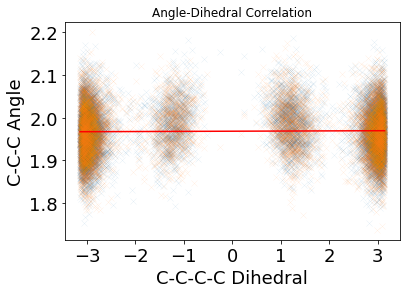

In [44]:
#Are the bond angle and dihedral correlated?

ang1=ang[:,0]
ang2=ang[:,1]

plt.scatter(CCCC_torsion,ang1,marker='x',linewidth=0.04)
plt.scatter(CCCC_torsion,ang2,marker='x',linewidth=0.04)

r=np.corrcoef(CCCC_torsion[:,0], ang1)
print("r2:",r[0,1])
line_fit=np.polyfit(CCCC_torsion[:,0],ang1,1)
x = np.linspace(min(CCCC_torsion[:,0]), max(CCCC_torsion[:,0]),20)
y = line_fit[0]*x+line_fit[1]
print(line_fit)
plt.plot(x,y,c='r',label='best fit line')
plt.xticks(size=18)
plt.yticks(size=18)
plt.xlabel('C-C-C-C Dihedral', size=18)
plt.ylabel('C-C-C Angle', size=18)
plt.title('Angle-Dihedral Correlation')

plt.show()


#plt.scatter(ang1[1:-1:10],ang2[1:-1:10])
#r=np.corrcoef(ang1, ang2)
#print("Angle Correlation r^2:",r[0,1])


**Homework Problem 3: Can you express the relationsip between these two quantites using histograms and conditional probabilities ?** 

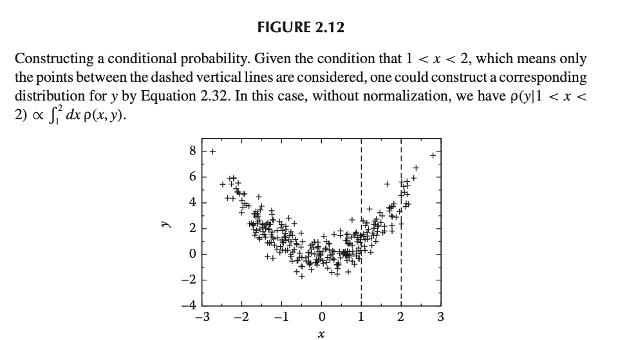

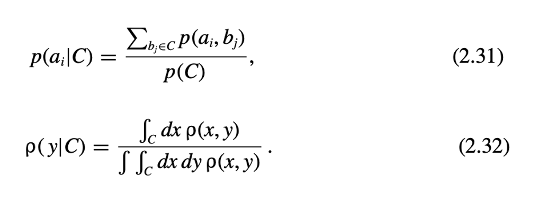

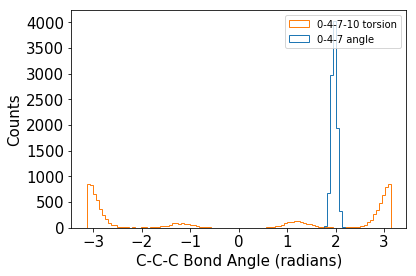

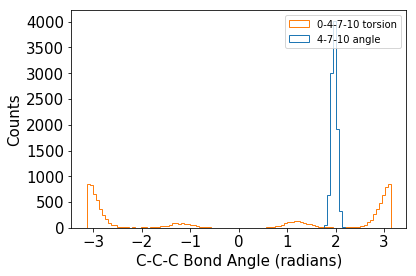

<Figure size 432x288 with 0 Axes>

In [27]:
#Homework problem 3##
compare1=[]
compare1.append(ang1)
#print(compare1)
compare1.append(CCCC_tor_ang)
#print(compare1)

plt.clf()
plt.hist(compare1,bins=100,histtype='step',label=['0-4-7 angle','0-4-7-10 torsion'])
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()
plt.clf()

compare2=[]
compare2.append(ang2)
#print(compare1)
compare2.append(CCCC_tor_ang)
#print(compare2)

plt.clf()
plt.hist(compare2,bins=100,histtype='step',label=['4-7-10 angle','0-4-7-10 torsion'])
plt.legend()
plt.xlabel('C-C-C Bond Angle (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()
plt.clf()

#I was not sure what to write for the rho function for the conditional probability.
#I was also not sure what to write for the bounds of the conditional probability.
#I probably would have done a frame by frame comparison of the torsions and the angles
#and then restricted either the angles or the torsions to certain values
#to see what sort of answer I would've gotten out.

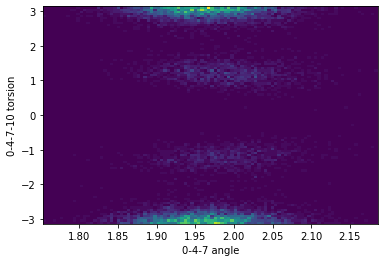

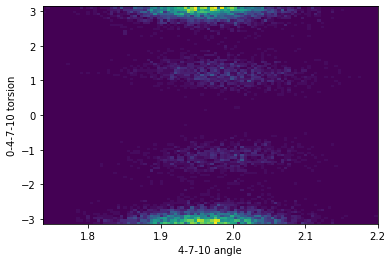

<Figure size 432x288 with 0 Axes>

In [50]:
#Homework problem 3##
#Basically for this HW problem, I just plotted two histograms. 
plt.hist2d(ang1, CCCC_tor_ang, bins=100)
plt.xlabel('0-4-7 angle')
plt.ylabel('0-4-7-10 torsion')
plt.show()
plt.clf()

plt.hist2d(ang2, CCCC_tor_ang, bins=100)
plt.xlabel('4-7-10 angle')
plt.ylabel('0-4-7-10 torsion')
plt.show()
plt.clf()

**Class Activity: Lets Calculate the Autocorrelation Times of C-C Bonds, C-C-C Angles, and C-C-C-C Dihedrals**

[0.00000000e+00 2.00020002e+00 4.00040004e+00 ... 1.99959996e+04
 1.99979998e+04 2.00000000e+04]


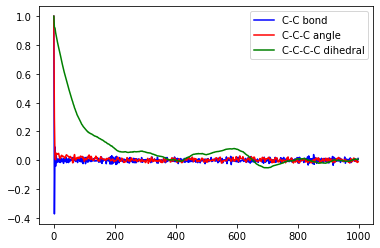

In [51]:
#Lets Calculate the autocorrelation times for bond lengths, bond angles, and torsions:
import numpy as np
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in picoseconds
time=np.linspace(0,20000,traj.n_frames)
print(time)

lags=range(500)
#C1C2bondlength[:,0]
bond_autocor=autocorr1(C1C2bondlength[:,0],lags)
ang_autocor=autocorr1(ang1,lags)
dihe_autocor=autocorr1(np.cos(CCCC_torsion[:,0]),lags)
plt.plot(time[lags],bond_autocor,color='b',label='C-C bond')
plt.plot(time[lags],ang_autocor,color='r',label='C-C-C angle')
plt.plot(time[lags],dihe_autocor,color='g',label='C-C-C-C dihedral')
plt.legend()

**Class Activity: Lets Dig Into force field XML file and make plots of the force field torsion terms**

Documentation of Torsion Term Conventions:

https://ambermd.org/doc12/Amber21.pdf#page=264

http://docs.openmm.org/latest/userguide/application/05_creating_ffs.html#basic-concepts

From Butane.gaff2.xml

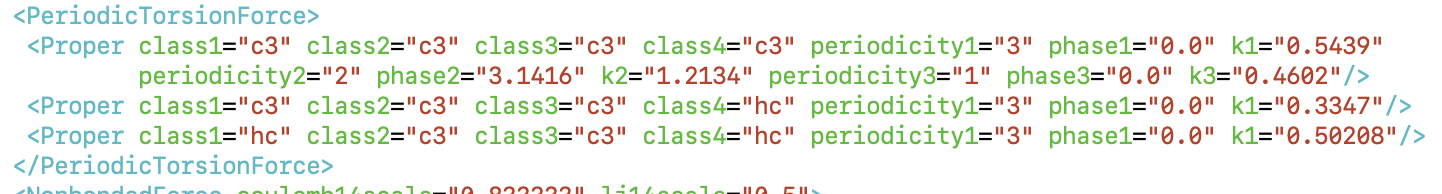

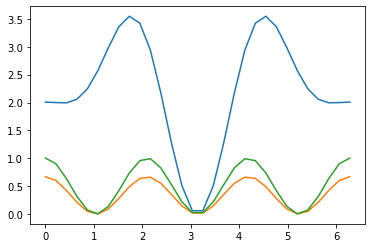

<Figure size 432x288 with 0 Axes>

In [52]:
#Plot The Torsion Force Field Terms

import math

#First Lets make a linespace from -pi to pi
rad_ang=np.linspace(0,2*math.pi,30)

##Lets right a function that takes paramters from the xml and writes the force field term

def calc_torsion_energy(angle,k1,period,phase):
     e=k1*(1+np.cos(period*angle-phase))
     return e

def CCCC_torsionE(angle):
 e1=calc_torsion_energy(angle,0.4602,1,0)
 e2=calc_torsion_energy(angle,1.2134,2,3.1416)
 e3=calc_torsion_energy(angle,0.5439,3,0)
 return e1+e2+e3

def CCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.3347,3,0)
 return e1

def HCCH_torsionE(angle):
 e1=calc_torsion_energy(angle,0.50208,3,0)
 return e1

CCCC_e=CCCC_torsionE(rad_ang)
CCCH_e=CCCH_torsionE(rad_ang)
HCCH_e=HCCH_torsionE(rad_ang)


plt.plot(rad_ang,CCCC_e)
plt.plot(rad_ang,CCCH_e)
plt.plot(rad_ang,HCCH_e)
plt.show()
plt.clf()


In [53]:
##Lets Review all our atoms as we attempt to tabulate all the relevant torsion terms
atoms, bonds = traj.topology.to_dataframe()
atoms

,serial,name,element,resSeq,resName,chainID,segmentID
0,1,C1,C,1,NBU,0,
1,2,H11,H,1,NBU,0,
2,3,H12,H,1,NBU,0,
3,4,H13,H,1,NBU,0,
4,5,C2,C,1,NBU,0,
5,6,H21,H,1,NBU,0,
6,7,H22,H,1,NBU,0,
7,8,C3,C,1,NBU,0,
8,9,H31,H,1,NBU,0,
9,10,H32,H,1,NBU,0,


 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

 <PeriodicTorsionForce>
  <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="3" phase1="0.0" k1="0.5439" 
          periodicity2="2" phase2="3.1416" k2="1.2134" periodicity3="1" phase3="0.0" k3="0.4602"/>
  <Proper class1="c3" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.3347"/>
  <Proper class1="hc" class2="c3" class3="c3" class4="hc" periodicity1="3" phase1="0.0" k1="0.50208"/>

In [54]:
#Lets Tally Up All The Torsions Along the Central Carbon
#Atomnames: (H41,H42,H43)-C4-C3(H31,H32)-C2(H21,H22)-C1(H11,H12,H13)
#Atomnumbers: (13,12,11)-10-(8,9)7-4(5,6)-0(1,2,3)


**Homework Problem #5: Many of These Correlations will be highly Correlated Select Some Torsions that are Correlated, and some that are not, and make scatter plots of their relationships**

For a Torsion Angle Pair that is highly correlated, can you find a relatively constant offset?  Why isn't it always the same?

For a Torsion Angle Pair that are less correlated, how can you interpret their scatter plots?

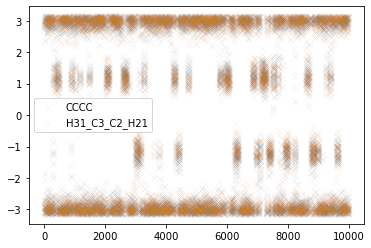

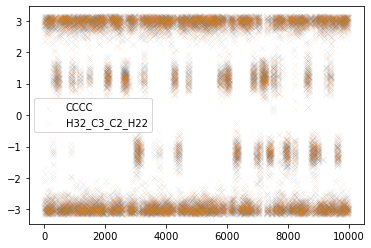

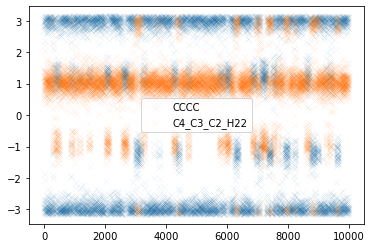

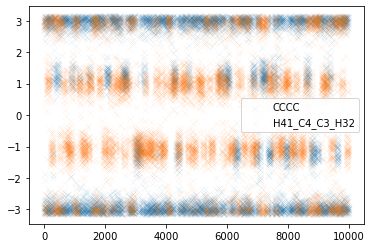

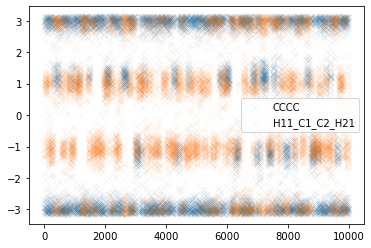

<Figure size 432x288 with 0 Axes>

In [55]:
####Homework Problem 5 - Correlations in torsion paramters###
#PLOT SOME TORSIONS THAT YOU EXPECT TO BE HIGHLY CORRELATED - EXPLAIN WHY - EXPLAIN WHAT OU SEE
#Consider CCCC vs. [8,7,4,5]

#def calc_torsion_energy(angle,k1,period,phase):

num_frames = range(1,10001)

#These atoms should all be relatively correlated because the middle two atoms
#(i.e., the atoms that make up the axis of rotation) are the same, so any rotation
#will result in a similar dihedral rotation for each. We can see this in their
#scatter plots where they each have similar patterns that are either overlapping
#or offset.

#We see an offset for a torsion angle pair when comparing the CCCC torsion
#to the C4_C3_C2_H22 torsion. Pehraps it's not always constant because the angles
#between C1 and H22 are not necessarily always constant, so a rotation of
#C2 will not necessarily result in C1 and H22 remaining the same angle apart.

indicies_CCCC = [10, 7, 4, 0]
indicies_H31_C3_C2_H21 = [8,7,4,5]

bond_torsions_CCCC_array = md.compute_dihedrals(traj, [indicies_CCCC])
bond_torsions_CCCC = bond_torsions_CCCC_array[:,0]
plt.scatter(num_frames,bond_torsions_CCCC,marker='x',linewidth=0.04,label="CCCC")

bond_torsions_H31_C3_C2_H21_array = md.compute_dihedrals(traj, [indicies_H31_C3_C2_H21])
bond_torsions_H31_C3_C2_H21 = bond_torsions_H31_C3_C2_H21_array[:,0]
plt.scatter(num_frames,bond_torsions_H31_C3_C2_H21,marker='x',linewidth=0.04,label="H31_C3_C2_H21")
plt.legend()
#plt.xlim(0,2000)
plt.show()
plt.clf()
#The legend is very faint, so you need to look very closely to see it.

bond_torsions_CCCC_array = md.compute_dihedrals(traj, [indicies_CCCC])
bond_torsions_CCCC = bond_torsions_CCCC_array[:,0]
plt.scatter(num_frames,bond_torsions_CCCC,marker='x',linewidth=0.04,label="CCCC")

indicies_H32_C3_C2_H22 = [9,7,4,6]

bond_torsions_H32_C3_C2_H22_array = md.compute_dihedrals(traj, [indicies_H32_C3_C2_H22])
bond_torsions_H32_C3_C2_H22 = bond_torsions_H32_C3_C2_H22_array[:,0]
plt.scatter(num_frames,bond_torsions_H32_C3_C2_H22,marker='x',linewidth=0.04,label="H32_C3_C2_H22")
plt.legend()
#plt.xlim(0,2000)
plt.show()
plt.clf()

bond_torsions_CCCC_array = md.compute_dihedrals(traj, [indicies_CCCC])
bond_torsions_CCCC = bond_torsions_CCCC_array[:,0]
plt.scatter(num_frames,bond_torsions_CCCC,marker='x',linewidth=0.04,label="CCCC")

indicies_C4_C3_C2_H22 = [10,7,4,6]

bond_torsions_C4_C3_C2_H22_array = md.compute_dihedrals(traj, [indicies_C4_C3_C2_H22])
bond_torsions_C4_C3_C2_H22 = bond_torsions_C4_C3_C2_H22_array[:,0]
plt.scatter(num_frames,bond_torsions_C4_C3_C2_H22,marker='x',linewidth=0.04,label="C4_C3_C2_H22")
plt.legend()
#plt.xlim(0,2000)
plt.show()
plt.clf()



#bond_torsions_CCCC_e = CCCC_torsionE(bond_torsions_CCCC)
#bond_torsions_H31_C3_C2_H21_e = HCCH_torsionE(bond_torsions_H31_C3_C2_H21)

#PLOT SOME TORSIONS THAT YOU EXPECT TO BE UNCORRELATED - Explain what you see
#Consider CCCC vs. [12,10,7,9]

#As shown below, when the torsion angle is less correlated, there is not 
#as much of a similar pattern (whether offset or overlapping). There isn't
#as much correlation from what we can see on the scatter plot.

indicies_CCCC = [10, 7, 4, 0]
indicies_H41_C4_C3_H32 = [12,10,7,9]

bond_torsions_CCCC_array = md.compute_dihedrals(traj, [indicies_CCCC])
bond_torsions_CCCC = bond_torsions_CCCC_array[:,0]
#bond_torsions_CCCC_e = CCCC_torsionE(bond_torsions_CCCC)
plt.scatter(num_frames,bond_torsions_CCCC,marker='x',linewidth=0.04,label="CCCC")

bond_torsions_H41_C4_C3_H32_array = md.compute_dihedrals(traj, [indicies_H41_C4_C3_H32])
bond_torsions_H41_C4_C3_H32 = bond_torsions_H41_C4_C3_H32_array[:,0]
#bond_torsions_H41_C4_C3_H32_e = CCCC_torsionE(bond_torsions_H41_C4_C3_H32)
plt.scatter(num_frames,bond_torsions_H41_C4_C3_H32,marker='x',linewidth=0.04,label="H41_C4_C3_H32")
plt.legend()
#plt.xlim(0,10000)
plt.show()
plt.clf()

plt.scatter(num_frames,bond_torsions_CCCC,marker='x',linewidth=0.04,label="CCCC")

indicies_H11_C1_C2_H21 = [1,0,4,5]

bond_torsions_H11_C1_C2_H21_array = md.compute_dihedrals(traj, [indicies_H11_C1_C2_H21])
bond_torsions_H11_C1_C2_H21 = bond_torsions_H11_C1_C2_H21_array[:,0]
plt.scatter(num_frames,bond_torsions_H11_C1_C2_H21,marker='x',linewidth=0.04,label="H11_C1_C2_H21")
plt.legend()
#plt.xlim(0,10000)
plt.show()
plt.clf()

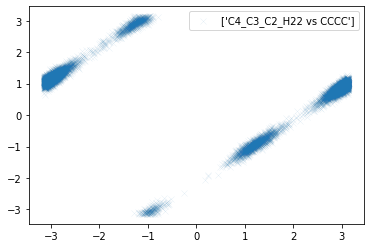

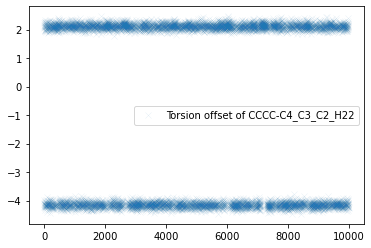

<Figure size 432x288 with 0 Axes>

In [56]:
#SELECT TWO TORSIONS THAT YOU EXPECT TO HAVE A SYSTEMATIC OFFSET 
#CALCULATE THEIR OFFSET IN EACH FRAME - EXPLAIN YOUR RESULT
#plt.scatter(CCCC_torsion,HCCH_torsions[:,1],marker='x',linewidth=0.04)
#diff=CCCC_torsion[:,0]-HCCH_torsions[:,3]

#In this graph, we see a linear relationship between the CCCC torsion
#and the C4_C3_C2_H22 torsion. This suggests that the offset is relatively
#constant. The reason for this offset is because C1 and H22 are both
#connected to C2 but at different angles, so there will always be a
#dihedral offset.

plt.scatter(bond_torsions_CCCC,bond_torsions_C4_C3_C2_H22,marker='x',linewidth=0.04,label=["C4_C3_C2_H22 vs CCCC"])
plt.legend()
#plt.xlim(0,10000)
plt.show()
plt.clf()

#As we see in this graph, the offset is relatively constant, taking 
#on mostly values of either -4 or 2 rads.

diff=bond_torsions_CCCC-bond_torsions_C4_C3_C2_H22
plt.scatter(num_frames,diff,marker='x',linewidth=0.04,label="Torsion offset of CCCC-C4_C3_C2_H22")
plt.legend()
#plt.xlim(0,10000)
plt.show()
plt.clf()



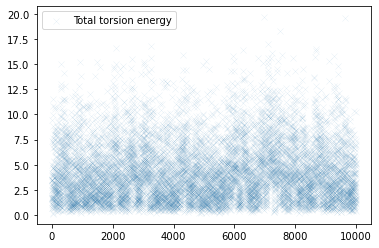

<Figure size 432x288 with 0 Axes>

In [57]:
#COMPUTE THE TOTAL TORSION FORCE FIELD ENERGY PER FRAME

#Variable to store TOTAL TORSION FORCE FIELD ENERGY PER FRAME

bond_torsions_e = [0]*10000

#Add up all the HCCH torsion energies

bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[1,0,4,5]])[:,0])
#print(bond_torsions_e)
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[1,0,4,6]])[:,0])
#print(bond_torsions_e)
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[2,0,4,5]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[2,0,4,6]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[3,0,4,5]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[3,0,4,6]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[5,4,7,8]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[5,4,7,9]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[6,4,7,8]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[6,4,7,9]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[11,10,7,8]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[11,10,7,9]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[12,10,7,8]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[12,10,7,9]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[13,10,7,8]])[:,0])
bond_torsions_e += HCCH_torsionE(md.compute_dihedrals(traj, [[13,10,7,9]])[:,0])
#print(bond_torsions_e)

#Add all the HCCC torsion energies to the total
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[1,0,4,7]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[2,0,4,7]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[3,0,4,7]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[8,7,4,0]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[9,7,4,0]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[5,4,7,10]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[6,4,7,10]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[11,10,7,4]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[12,10,7,4]])[:,0])
bond_torsions_e += CCCH_torsionE(md.compute_dihedrals(traj, [[13,10,7,4]])[:,0])
#print(bond_torsions_e)

#Add CCCC torsion energies to the total
bond_torsions_e += CCCC_torsionE(md.compute_dihedrals(traj, [[0,4,7,10]])[:,0])
#print(bond_torsions_e)

plt.scatter(num_frames,bond_torsions_e,marker='x',linewidth=0.04,label="Total torsion energy")
plt.legend()
#plt.xlim(0,10000)
plt.show()
plt.clf()

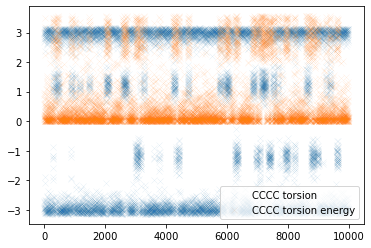

<Figure size 432x288 with 0 Axes>

In [58]:
#Compare the time course of CCCC torsion with its energy 
#Interpret what you are seeing in terms of conformations and energies

plt.scatter(num_frames,bond_torsions_CCCC,marker='x',linewidth=0.04,label="CCCC torsion")
plt.scatter(num_frames,CCCC_torsionE(md.compute_dihedrals(traj, [[0,4,7,10]])[:,0]),marker='x',linewidth=0.04,label="CCCC torsion energy")
plt.legend()
#plt.xlim(0,10000)
plt.show()
plt.clf()

#It appears that the rarer CCCC angles appear at the same frames as the rarer/
#higher CCCC torsion energies. This makes sense because if a certain conformation
#is higher in energy, then it should appear less often.

Plot The Total Torsion Energy As a Function of the C-C-C-C Dihedral Angle - Compare your plot Energetic Torsion Barriers from Cramer.  How Can you explain the Difference?

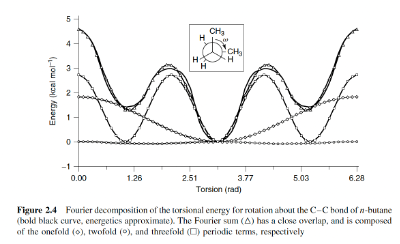

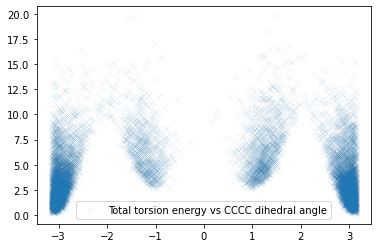

<Figure size 432x288 with 0 Axes>

In [59]:
#Solution
plt.scatter(bond_torsions_CCCC,bond_torsions_e,marker='x',linewidth=0.04,label="Total torsion energy vs CCCC dihedral angle")
plt.legend()
plt.show()
plt.clf()

#It appears that my distribution is flipped relative to Cramer's on first glance.
#However, if we look at the x-axis, we can see it's just offset and that you 
#would get a similar result as Cramer if you were just to look at 0 radians and up.
#The y-axis also seems different, but that is probably because of a change in
#units.

***Homework Problem #6: Lets modify the C-C-C-C Torsion Potential to change the dihedral distribution***


Lets try to lower the dihedral barriers for torsion angles of 1 radian (~60 degrees)
This means we need to to come up with a torsion potential, potentially by using multiple terms with different phases, to equalize the free energy of each C-C-C-C torsion basin (increasing the free energy at $\pi$ and lowering 
free energy at $\pi$/3

Once you've come up with torsion terms you're happy with, you'll need to make a copy of the butane.gaff2.xml, add in the additional torsion terms you have come up with, and run a new simulation.  Then plot the C-C-C-C dihedral histogram or PMF, and compare it to the simulation with original force field.

It would be great if you came up with some kind of fitting routine to determine the coefficients of torsions, perhaps by targeting a gaussian, or you can try to arrive at by hand using something like this:

https://www.desmos.com/calculator/ea1qhzjnuf

In [60]:
###SOLUTION#####

#There were not that many changes I needed to make to get a good fit.
#(See slack message for a picture of my fit.)
#Specifically, the changes I made are listed here:
#k1 = -0.67 --> 1.3
#k2 = -0.55 --> -0.525
#These changes are also in my xml file.
#I only applied these corrections to the CCCC atom and was not sure if
#I should've applied them for some of the H atoms.
#What I changed in the file:   <Proper class1="c3" class2="c3" class3="c3" class4="c3" periodicity1="1" phase1="0.0" k1="1.3"
#          periodicity2="1" phase2="0.0" k2="-0.525" periodicity3="1" phase3="0.0" k3="-0.5"/>

***Homework Problem #7: Attempt to run a new MD Simulation with your modified torsion potential***

Once you have made a torsion correction you like make a new force field file 'butane.gaff2.cor1.xml'.

Run a new simulation with this force field and compare the dihedral distributions 

In [3]:
#RUN NEW MD SIMULATION HERE#

from simtk.openmm import app
import simtk.openmm as mm
from simtk import unit
import mdtraj as md
from sys import stdout
import time as time
import ipywidgets
from ipywidgets import interact, fixed
import warnings
import nglview as ngl
from nglview.player import TrajectoryPlayer
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import os

datadir='/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2'
workDir='/Users/albertchen/Desktop/CHEM.101.6/Project_1/outdir'
initial_pdb='/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2/butane.pdb'
force_field='/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2/butane.gaff2.cor1.xml'

if not os.path.exists(workDir):
    os.makedirs(workDir)
    
print(initial_pdb)
print(force_field )

pdb = mm.app.PDBFile(initial_pdb)
forcefield = mm.app.ForceField(force_field)


system = forcefield.createSystem(pdb.topology, nonbondedMethod=mm.app.NoCutoff, constraints=mm.app.HBonds)
integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

platform = mm.Platform.getPlatformByName('Reference')
simulation = app.Simulation(pdb.topology, system, integrator, platform)
simulation.context.setPositions(pdb.positions)



integrator = mm.LangevinIntegrator(298.15*unit.kelvin, 5.0/unit.picoseconds, 2.0*unit.femtoseconds)
integrator.setConstraintTolerance(1e-5)

print('Minimizing...')

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy before minimization is {st.getPotentialEnergy()}")

simulation.minimizeEnergy(maxIterations=100)

st = simulation.context.getState(getPositions=True,getEnergy=True)
print(F"Potential energy after minimization is {st.getPotentialEnergy()}")



from sys import stdout

print('Equilibrating...')

simulation.reporters.append(app.StateDataReporter(stdout, 100, step=True, 
    potentialEnergy=True, temperature=True, separator=','))
simulation.context.setVelocitiesToTemperature(150.0*unit.kelvin)
simulation.step(2500)



import time as time

print('Running Production...')

# Begin timer
tinit=time.time()

# Clear simulation reporters
simulation.reporters.clear()

# Reinitialize simulation reporters. We do this because we want different information printed from the production run than the equilibration run.
# output basic simulation information below every 250000 steps - (which is equal to 2 fs(250,000) = 500,000 fs = 500 ps)
simulation.reporters.append(app.StateDataReporter(stdout, 250000, 
    step=True, time=True, potentialEnergy=True, temperature=True, 
    speed=True, separator=','))

# write out a trajectory (i.e., coordinates vs. time) to a DCD
# file every 100 steps - 0.2 ps
simulation.reporters.append(app.DCDReporter('butane_sim_cor1.dcd', 100))

# run the simulation for 1.0x10^7 steps - 20 ns
simulation.step(1000000)

# End timer
tfinal=time.time()
print('Done!')
print('Time required for simulation:', tfinal-tinit, 'seconds')




/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2/butane.pdb
/Users/albertchen/Desktop/CHEM.101.6/Project_1/data-2/butane.gaff2.cor1.xml
Minimizing...
Potential energy before minimization is 5.796706865997784 kJ/mol
Potential energy after minimization is 5.298273837901903 kJ/mol
Equilibrating...
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
100,27.175789397491535,274.5643865047256
200,36.43231356671182,262.15380623013993
300,46.86842288259311,148.7109084038551
400,43.275824516389555,366.1383579645625
500,34.4440644014682,296.9139709029466
600,42.45717282001343,240.51524045098694
700,29.650055753945892,252.64083998293523
800,31.773435787443958,262.3050078920829
900,27.607584086775187,382.0652087845724
1000,22.63778181251469,515.6926908988594
1100,35.27234162024,257.1109911689504
1200,32.186414161247974,380.31730025437724
1300,48.317836811936274,477.2702134850004
1400,40.83069522267553,356.318637580523
1500,46.87110953300535,396.40270598233235
1600,84.74681735116663,262.1774

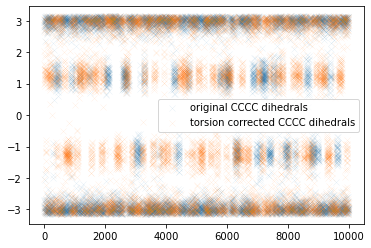

<Figure size 432x288 with 0 Axes>

In [8]:
#print(workDir+'butane_sim.dcd')
#simulation.reporters.append(app.DCDReporter(workDir+'butane_sim.dcd', 100))
traj = md.load('butane_sim_cor1.dcd', top=initial_pdb)
traj

#traj = md.load('butane_sim_cor1.dcd', top=initial_pdb)
t = ngl.MDTrajTrajectory(traj)
w = ngl.NGLWidget(t)
w



atoms, bonds = traj.topology.to_dataframe()
atoms



#Lets select the topology
top=traj.topology
top

traj2 = md.load('butane_sim.dcd', top=initial_pdb)
traj2

num_frames = range(1,10001)
#My original dihedrals from earlier before my new torsion-corrected simulations.
plt.scatter(num_frames,md.compute_dihedrals(traj2, [[0,4,7,10]])[:,0],marker='x',linewidth=0.04,label="original CCCC dihedrals")
plt.scatter(num_frames,md.compute_dihedrals(traj, [[0,4,7,10]])[:,0],marker='x',linewidth=0.04,label="torsion corrected CCCC dihedrals")
plt.legend()
plt.show()
plt.clf()

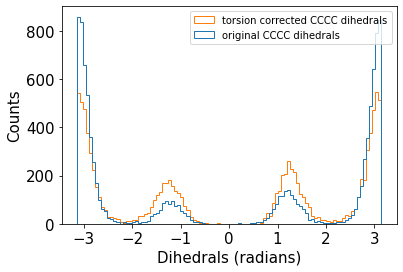

<Figure size 432x288 with 0 Axes>

In [9]:
#We can see above that the values of the dihedrals have not seemed to change much.
#Let's also use a histogram to check.

plt.clf()
plt.hist([md.compute_dihedrals(traj2, [[0,4,7,10]])[:,0],
         md.compute_dihedrals(traj, [[0,4,7,10]])[:,0]],bins=100,histtype='step',
         label=['original CCCC dihedrals','torsion corrected CCCC dihedrals'])
plt.legend()
plt.xlabel('Dihedrals (radians)', size=15)
plt.xticks(size=15)
plt.ylabel('Counts', size=15)
plt.yticks(size=15)
plt.show()
plt.clf()
#As we can see below, the torsion corrected dihedrals don't seem to take on many new values. However, the 
#frequency at which they take on certain values seems to have changed.

**Homework Problem #8:  Calculate LJ and Coulumb Forcefield Potentials for 3 types of atom pairs**

**Challenge Problem:  Atempt to calculate all LJ interactions for a frame and all frames.  What does lj14scale mean?**


**Challenge Problem #2:  Attempt to calculate all Coulumb interactions for a frame and all frames**

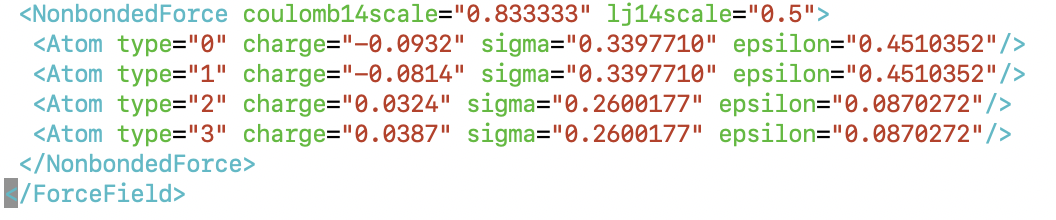




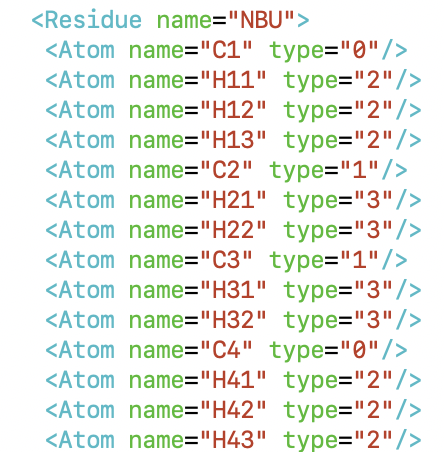

[-0.19745129799246283, 4.193842528243353e+17]


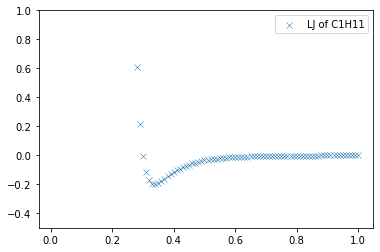

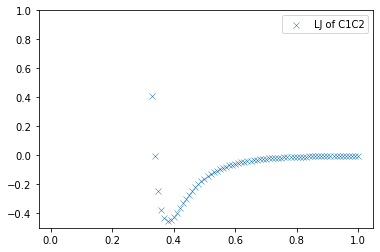

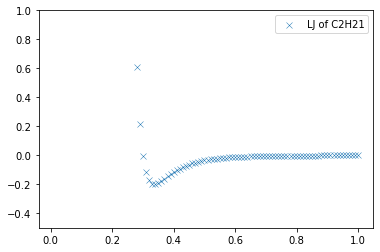

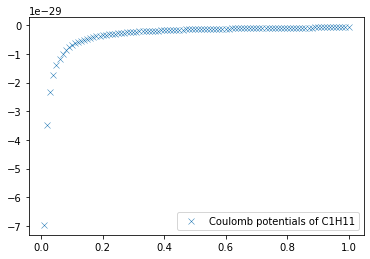

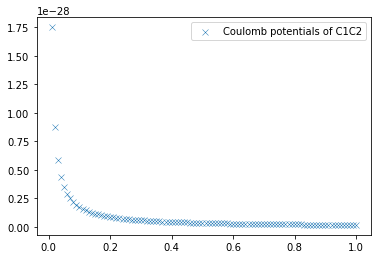

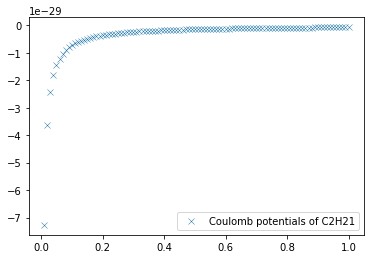

<Figure size 432x288 with 0 Axes>

In [19]:
#Calculate LJ and Couloumb Potentionals Here

import math
import numpy as np

#Calculation of LJ

def calc_LJ_CH3(dist):
    epsilon = (0.4510352*0.0870272)**0.5
    sigma = 0.5*(0.3397710+0.2600177)
    A=4*epsilon*(sigma**12)
    B=4*epsilon*(sigma**6)
    return A/(dist**12) - B/(dist**6)

def calc_LJ_CC(dist):
    epsilon = (0.4510352*0.4510352)**0.5
    sigma = 0.5*(0.3397710+0.3397710)
    A=4*epsilon*(sigma**12)
    B=4*epsilon*(sigma**6)
    return A/(dist**12) - B/(dist**6)

def calc_LJ_CH2(dist):
    epsilon = (0.4510352*0.0870272)**0.5
    sigma = 0.5*(0.3397710+0.2600177)
    A=4*epsilon*(sigma**12)
    B=4*epsilon*(sigma**6)
    return A/(dist**12) - B/(dist**6)

def get_min_max(num_list):
    min_max = []
    min_max.append(min(num_list))
    min_max.append(max(num_list))
    return min_max

epsilon_naught = 8.854187817*(10**(-12))

#Calculation of coulomb potential (formula from lecture).
#Make sure to convert elmentary charge 
#to coulombs so the charge units match epsilon naught's.

def calc_coul_CH3(dist):
    c_charge_CH3 = -0.0932*1.60218*(10**(-19))
    h_charge_CH3 = 0.0324*1.60218*(10**(-19))
    return (c_charge_CH3*h_charge_CH3)/(4*math.pi*epsilon_naught*dist)

def calc_coul_CC(dist):
    c_charge_CH3 = -0.0932*1.60218*(10**(-19))
    c_charge_CH2 = -0.0814*1.60218*(10**(-19))
    return (c_charge_CH3*c_charge_CH2)/(4*math.pi*epsilon_naught*dist)
    
def calc_coul_CH2(dist):
    c_charge_CH2 = -0.0814*1.60218*(10**(-19))
    h_charge_CH2 = 0.0387*1.60218*(10**(-19))
    return (c_charge_CH2*h_charge_CH2)/(4*math.pi*epsilon_naught*dist)

#Get a range of distances between the min and max for each bond type.

C1H11bondlength = md.compute_distances(traj, [[0, 1]])
C1C2bondlength = md.compute_distances(traj, [[0, 4]])
C2H21bondlength = md.compute_distances(traj, [[4, 5]])

min_max_C1H11bondlength = get_min_max(C1H11bondlength[:,0])
min_max_C1C2bondlength = get_min_max(C1C2bondlength[:,0])
min_max_C2H21bondlength = get_min_max(C2H21bondlength[:,0])

C1H11_dists = np.linspace(0.01, 1, num =100)
C1C2_dists = np.linspace(0.01, 1, num =100)
C2H21_dists = np.linspace(0.01, 1, num =100)


#Calc the LJs for these distances and plot.

LJ_C1H11 = calc_LJ_CH3(C1H11_dists)
test = get_min_max(LJ_C1H11)
print(test)


plt.scatter(C1H11_dists,LJ_C1H11,marker='x',linewidth=0.5,label="LJ of C1H11")
plt.ylim(-.5,1)
plt.legend()
plt.show()
plt.clf()

LJ_C1C2 = calc_LJ_CC(C1C2_dists)

plt.scatter(C1C2_dists,LJ_C1C2,marker='x',linewidth=0.5,label="LJ of C1C2")
plt.ylim(-.5,1)
plt.legend()
plt.show()
plt.clf()

LJ_C2H21 = calc_LJ_CH2(C2H21_dists)

plt.scatter(C2H21_dists,LJ_C2H21,marker='x',linewidth=0.5,label="LJ of C2H21")
plt.ylim(-.5,1)
plt.legend()
plt.show()
plt.clf()

#Calc the coulombs for these distances and plot.
coul_C1H11 = calc_coul_CH3(C1H11_dists)

plt.scatter(C1H11_dists,coul_C1H11,marker='x',linewidth=0.5,label="Coulomb potentials of C1H11")
plt.legend()
plt.show()
plt.clf()

coul_C1C2 = calc_coul_CC(C1C2_dists)

plt.scatter(C1C2_dists,coul_C1C2,marker='x',linewidth=0.5,label="Coulomb potentials of C1C2")
plt.legend()
plt.show()
plt.clf()

coul_C2H21 = calc_coul_CH2(C2H21_dists)

plt.scatter(C2H21_dists,coul_C2H21,marker='x',linewidth=0.5,label="Coulomb potentials of C2H21")
plt.legend()
plt.show()
plt.clf()

#The colution key did help me understand a bit about how to limit the distances.

In [41]:
###SOLUTION###
#ONCE YOU HAVE FOUND SOME TORSION CORRECTIONS RUN A NEW SIMULATION 
#Make a new force field file 'butane.gaff2.cor1.xml'


**Weekly Conceptual Check-in**

One of the concepts we discussed in class that relates to this simulation is the idea of potential energy surfaces, as the paper discusses how the native binding poses are likely the global enegetic minima. I think this really connects to the idea of molecular dynamics, where molecules can from local minima to even lower energy minima (or the native binding pose here). The fact that it can go to the native binding pose even when placed at random locations further highlights this idea of being able to go from local energy minima to global energy minima. One thing I noticed was was how these inhibitors sometimes become bound and stuck within allosteric binding sites and do not go to their native binding poses (i.e., the global minima). In terms of additional simulations to run, I do wonder if running the simulation for longer than 115 microseconds would eventually result in the molecule binding at the native binding pose. Or would it remain stuck at these local minima?

Following this new simulation, if there are some cases in which this molecule leaves these allosteric sites to go to the native binding pose, could we express the probability of leaving these sites as a conditional probability? Maybe such new analyses of conditional probability could tell us how robust a drug molecule is--how good it is at exiting a "sticky" situation and performing its original task even when things go wrong.